# Breast Cancer Diagnosis:
### Using data from Kaggle 
### Find and tune the best model to help detect if a person has Breast Cancer

In [34]:
# get the current directory and access the file 
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns



In [28]:
def return_data_path(file_name):
    current_directory = os.getcwd()
    # Construct the path to the CSV file two levels up and into the data_folder
    file_path = os.path.join(current_directory, '..', 'Data', file_name)
    # Normalize the path
    normal_path = os.path.normpath(file_path)
    print(f"Normal Path: {normal_path}")
    return normal_path



In [29]:
df = pd.read_csv(return_data_path('Breast_cancer_data.csv'))

Normal Path: /Users/robertocandelario/Desktop/Python_Learning/Hands On Machine Learning/Data/Breast_cancer_data.csv


In [30]:
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [33]:
df.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


#### Studying the noisiness and type of noise 

array([[<Axes: title={'center': 'mean_radius'}>,
        <Axes: title={'center': 'mean_texture'}>],
       [<Axes: title={'center': 'mean_perimeter'}>,
        <Axes: title={'center': 'mean_area'}>],
       [<Axes: title={'center': 'mean_smoothness'}>,
        <Axes: title={'center': 'diagnosis'}>]], dtype=object)

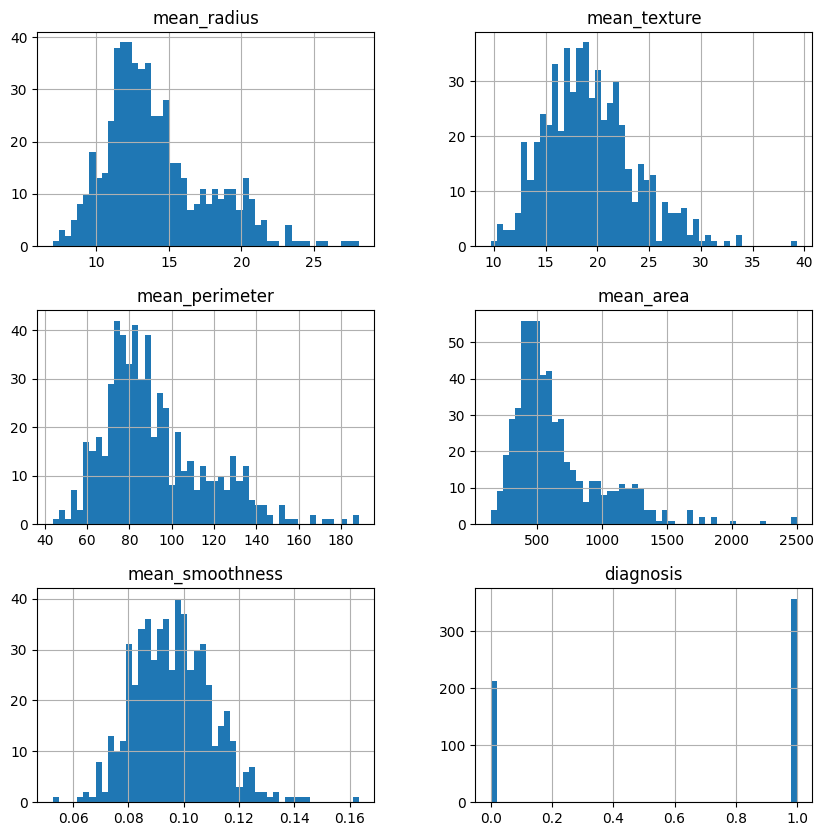

In [38]:
df.hist(bins=50, figsize=(10,10))

The histogram above is showing us that  
Mean radius, mean_perimeter and mean_area are skwed,  
mean_texture has an outlier,  
mean_smoothness has a 2-3 peaks.


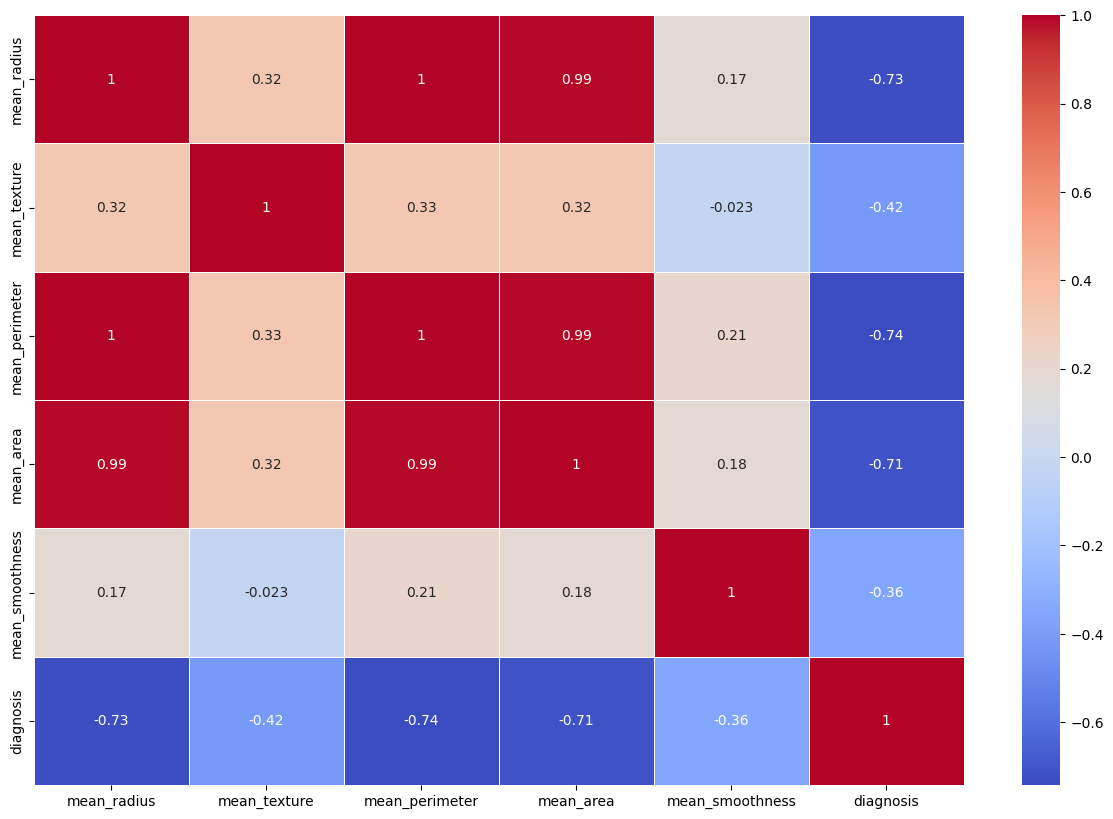

In [40]:
#calculate the correlations matrix
corr_matrix = df.corr()

#plot the heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

mean_radius and mean_perimeter look to be very correlated with eachouther, I will be removing one of them 

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(df[['mean_radius', 'mean_perimeter', 'mean_area']])
print(vif_df)

          Feature          VIF
0     mean_radius  3240.445403
1  mean_perimeter  3583.747992
2       mean_area    25.830809


### Split the data into training and test sets 

In [45]:
from sklearn.model_selection import train_test_split

## Split the data into x and y values 
x = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42, test_size=0.30)

## Making pipline and applying appropirate transformation to each feature

In [47]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

# First we want to take the log of the feature with outliers -  mean_testure
# lets define the transfomration steps
log_transformer = FunctionTransformer(np.log1p, validate=True)
scaler = StandardScaler()

#Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, ['mean_texture']),
        ('scale', scaler, ['mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness'])
    ])

# Create a complete pipleine 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply the pipeline to the data

X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)



In [50]:
# First model we will use is 
# SVC Model
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svc = SVC(kernel='rbf', class_weight='balanced')

# evaluate the models performance with recall - recall becase we want to make sure we are making the last amout of mistakes 
scores = cross_val_score(svc, X_train_transformed, y_train, cv=5, scoring='recall')

In [51]:
print(f"Recall score: {scores}")
print(f"Mean Recall score: {scores.mean()}")

Recall score: [0.94 0.94 0.98 0.9  0.96]
Mean Recall score: 0.944


In [56]:
## Lets train the a random forest model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create the random forest mdoel
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced')

# Evaluate the model performance with recall
scores = cross_val_score(rf, X=X_train_transformed, y=y_train, cv=5, scoring='recall')

In [57]:
print(f"Recall score: {scores}")
print(f"Mean Recall score: {scores.mean()}")

Recall score: [0.94 0.98 0.98 0.96 0.98]
Mean Recall score: 0.968


In [66]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

xgb = XGBClassifier(n_estimators = 100, max_depth=10, learning_rate= 0.05 )

scores = cross_val_score(xgb, X_train_transformed, y_train, cv=5, scoring='recall')


In [67]:
print(f"Recall score: {scores}")
print(f"Mean Recall score: {scores.mean()}")

Recall score: [0.86 0.96 0.98 0.92 0.98]
Mean Recall score: 0.9399999999999998
